In [1]:

#src->dataset contains program to download,transform and prepare the dataset

"""
src->dataset->download_dataset contains class for downloading and unpacking
datasets for
    -- Mini CoCo dataset : Downloaded and extracted from an github repo
    -- CIFAR-100 dataset : Downloaded through torchvision library
    -- OxfordIIITPet dataset : Downloaded through torchvision library
"""

# if you encounter error (I usually observe this on cloud gpu notebooks): please try
# pip install -U --no-cache-dir gdown --pre 

from src.dataset import download_dataset

#:param dataset_name: can be "mini_coco","cifar","oxford_pet"
train_dataset_downloader=download_dataset.DownloadDataset(dataset_name="mini_coco")
train_dataset_downloader.download_from_url(url='1t_l9uyBPfxSEzcajTk4a1TaQXzeRm9hw')

# train_dataset_downloader=download_dataset.DownloadDataset(dataset_name="cifar")
# train_dataset_downloader.download_from_torch()
#
# train_dataset_downloader=download_dataset.DownloadDataset(dataset_name="oxford_pet")
# train_dataset_downloader.download_from_torch()


Mini coco dataset from https://github.com/giddyyupp/coco-minitrain repo


Downloading...
From: https://drive.google.com/uc?id=1t_l9uyBPfxSEzcajTk4a1TaQXzeRm9hw
To: /notebooks/Poly2/data/raw/dataset.zip
100%|██████████| 4.90G/4.90G [01:09<00:00, 70.2MB/s]



 Finished downloading and unpacking Mini coco dataset


In [1]:
#src->dataset contains program to download,transform and prepare the dataset

"""
src->dataset->prepare_dataset contains functions to load input images and sobel/random filter images

image folder for "mini_coco" : "data/raw/coco_minitrain_25k/images/train2017"
image folder for "oxford pet" : "data/raw/oxford-iiit-pet/images"

image size of 128 is selected for both Autoencoder and Pix2Pix Model

filter can be "sobel" to apply sobel filter
"random" to apply random filter (extra credit)

this interim data is stored in static location- data->interim for simplification
"""

from src.dataset import prepare_dataset
images,ground_truths=prepare_dataset.prepare_img_and_gt_folder(folder="data/raw/coco_minitrain_25k/images/train2017",
                                                        img_size=128,
                                                        filter="random",
                                                        save=True)

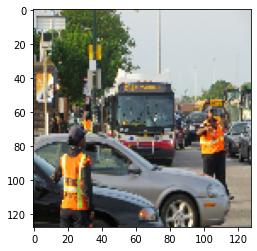

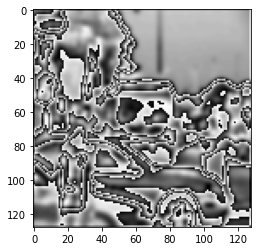

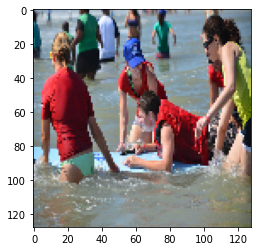

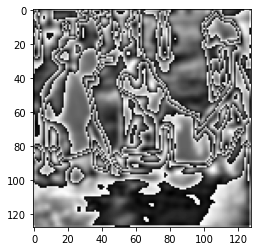

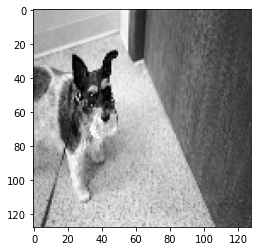

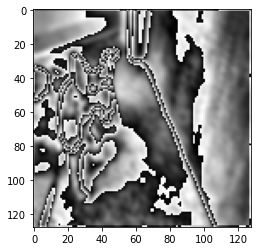

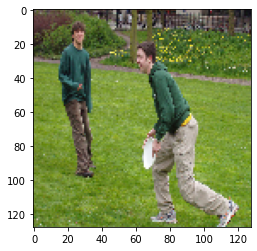

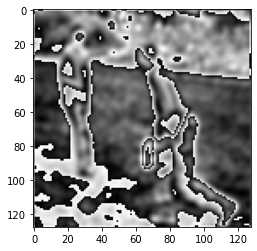

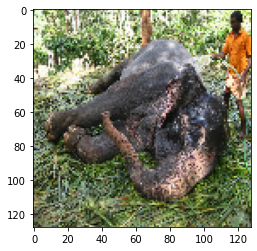

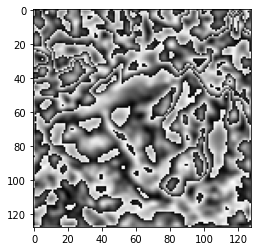

In [2]:
# Visualizing images and corresponding filtered images

import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(images[i])
    plt.show()

    plt.imshow(ground_truths[i],cmap="gray")
    plt.show()

In [3]:
#src->dataset contains program to download,transform and prepare the dataset

from src.dataset import prepare_dataset
from src.dataset import load_torch_dataset
from torchvision import transforms

# to save time, we can load from interim itself
import numpy as np
images=np.load("data/interim/images.npy")
ground_truths=np.load("data/interim/ground_truths.npy")

"""
src->prepare_dataset contains
:func :randomly_select, which can be used to select random portion of the dataset
in the view of GPU memory limitation

:func :split_dataset contains code to split the dataset into training,testing and validation
"""

images,ground_truths=prepare_dataset.randomly_select(images=images,gts=ground_truths,n=7000)

train_images,val_images,test_images\
,train_ground_truths,val_ground_truths,test_ground_truths=prepare_dataset.split_data(images=images,gts=ground_truths,test_size=0.2,val_size=0.25)

"""
src->load_torch_dataset provide Custom Pytorch Dataset Class tailored for this project
"""
train_dataset=load_torch_dataset.Img2ImgDataset(train_images,train_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
val_dataset=load_torch_dataset.Img2ImgDataset(val_images,val_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=load_torch_dataset.Img2ImgDataset(test_images,test_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
# src->training-> gen_hparams provide function to handle all parameters used in this project

from src.experiment import gen_hparams

"""
    outputs a dictionary data structure of hyper parameters

    :param image_size: image size which was resized
    :param max_epochs: epochs
    :param batch_size: batch size of the training dataset
    :param device: cuda or cpu
    :param gpu: pytorch ligthning trainer gpu option
    :param generator_dropout_p: Generator Architecture dropout values
    :param discriminator_dropout_p: Discriminator Architecture dropout values
    :param generator_lr: learning rate of the generator
    :param discriminator_lr: learning rate of the discriminator
    :param weight_decay: weight decay for optimizers for L2 regularization
    :param lr_scheduler_T_0: Learning rate scheduler - Number of iterations for the first restart.
    :param lr_scheduleer_T_mult: Learning rate scheduler - A factor increases T_{i}T after a restart. Default: 1.
    :param lbda: weight in generator loss
    :param input_channel: 3 if RGB or 1 if Gray
    :param output_channel: 3 if RGB or 1 if Gray
    :return: dict of hyperparameters
"""
hparams=gen_hparams.get_hparams(
image_size=128,
max_epochs=5,
batch_size=32,
gpu=1,
generator_dropout_p=0.4,
discriminator_dropout_p=0.4,
generator_lr=1e-3,
discriminator_lr=1e-6,
weight_decay=1e-5,
lr_scheduler_T_0=70*2,
lr_scheduler_T_mult=2,
device="cuda",
lbda=100,
input_channel=3,
output_channel=1
)

In [5]:
# src->models contains the pix2pix model
from src.models import pix2pix

# Generator input channel is 3 because input is RGB image
# Output channel is 1 because ground truth is Gray Scale image
generator=pix2pix.Generator(dropout_p=hparams["generator_dropout_p"],input_channel=hparams["input_channel"],output_channel=hparams["output_channel"])
# Discriminator Input Channel is concatented 3 channel and 1 channel image, therefore 4
discriminator=pix2pix.Discriminator(dropout_p=hparams["discriminator_dropout_p"],input_channel=4)



/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.
  rank_zero_warn(
wandb: Currently logged in as: xatwik. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 24.4 M
1 | discriminator | Discriminator | 12.4 M
------------------------------------------------
36.8 M    Trainable params
0         Non-trainable params
36.8 M    Total params
147.357   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `D

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


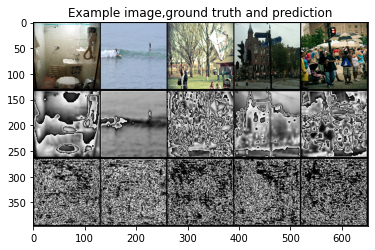

Validation: 0it [00:00, ?it/s]

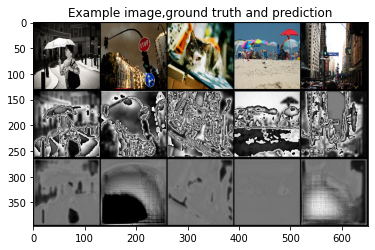

Validation: 0it [00:00, ?it/s]

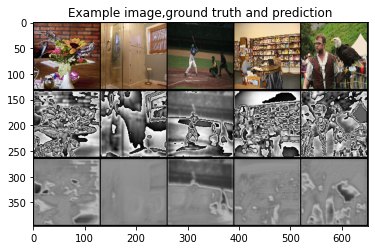

Validation: 0it [00:00, ?it/s]

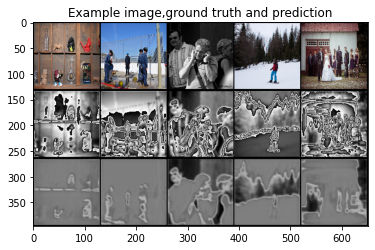

Validation: 0it [00:00, ?it/s]

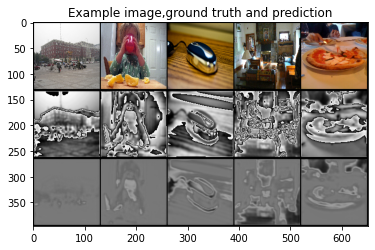

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [6]:
# src->experiment contains the pix2pix model pytorch lightning trainer
from src.experiment import train

import pytorch_lightning as pl
from torch.utils.data import DataLoader
#from pytorch_lightning.loggers import WandbLogger

model=train.Pix2Pix(hparams,generator,discriminator)

#wandb_logger = WandbLogger(project='poly',log_model="all" )
trainer = pl.Trainer(max_epochs=hparams["max_epochs"],gpus=hparams["gpu"],default_root_dir="models/")

train_dataloader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)


trainer.fit(model,train_dataloader,val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

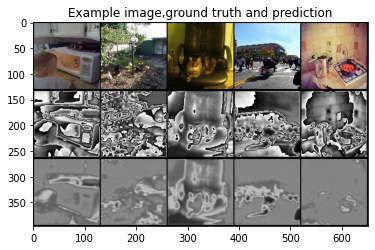

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     avg_test_g_psnr        10.997491836547852
     avg_test_g_ssim        0.4142613708972931
       test_g_psnr          10.997491836547852
       test_g_ssim          0.4142614006996155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_g_psnr': 10.997491836547852,
  'test_g_ssim': 0.4142614006996155,
  'avg_test_g_psnr': 10.997491836547852,
  'avg_test_g_ssim': 0.4142613708972931}]

In [7]:
# this is the testing result
trainer.test(model,test_dataloader)


In [10]:
# from here it gets rough again mate

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

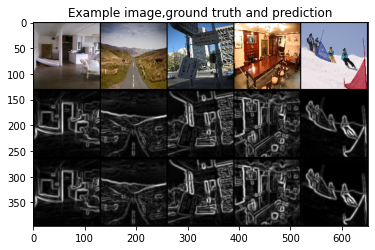

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_g_psnr           28.25682258605957
       test_g_ssim          0.9466993808746338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_g_psnr': 28.25682258605957, 'test_g_ssim': 0.9466993808746338}]

In [11]:
import torch
from src.experiment import train

model = train.Pix2Pix.load_from_checkpoint("models/epoch=4-step=1320.ckpt",hparams=torch.load("models/epoch=4-step=1320.ckpt")["hyper_parameters"])
model.eval()
trainer.test(model,test_dataloader)

In [25]:
# src->testing contains code to test single image
from src.testing import test_single_img
image, gt = test_single_img.load_single_image("figures/test1.jpg", [128, 128], "cpu")

from src.experiment import train
model = train.Pix2Pix.load_from_checkpoint("models/epoch=4-step=1320.ckpt",hparams=torch.load("models/epoch=4-step=1320.ckpt")["hyper_parameters"])
model.eval()

predicted=model(image)

plt.imshow(gt[0].permute(1,2,0).detach().numpy(),cmap="gray")
plt.title("Ground Truth")
plt.show()

plt.imshow(predicted[0].permute(1,2,0).detach().numpy(),cmap="gray")
plt.title("Predicted Image")
plt.show()

from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim

psnr = psnr(predicted[0],gt[0])
print("PSNR: "+str(psnr))
ssim = ssim(predicted,gt)
print("SSIM: "+str(ssim))


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperpa

Testing: 0it [00:00, ?it/s]

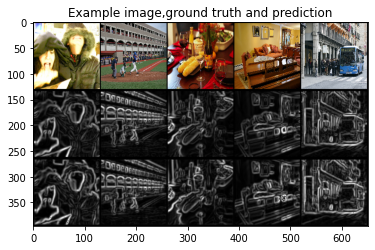

{'avg_test_g_psnr': tensor(28.1914, device='cuda:0'), 'avg_test_g_ssim': tensor(0.9453, device='cuda:0')}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_g_psnr           28.19135093688965
       test_g_ssim          0.9452572464942932
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_g_psnr': 28.19135093688965, 'test_g_ssim': 0.9452572464942932}]

In [3]:
# testing on entirely new dataset

from torch.utils.data import DataLoader
import torch
from src.dataset import load_torch_dataset
from src.experiment import train

from torchvision import transforms
import pytorch_lightning as pl

from src.experiment import gen_hparams

hparams=gen_hparams.get_hparams(
image_size=128,
max_epochs=5,
batch_size=1000,
gpu=1,
generator_dropout_p=0.4,
discriminator_dropout_p=0.4,
generator_lr=1e-3,
discriminator_lr=1e-6,
weight_decay=1e-5,
lr_scheduler_T_0=70*2,
lr_scheduler_T_mult=2,
device="cuda",
lbda=100,
input_channel=3,
output_channel=1
)

trainer = pl.Trainer(max_epochs=hparams["max_epochs"],gpus=hparams["gpu"])


images,ground_truths=prepare_dataset.prepare_img_and_gt_folder(folder="data/raw/coco_minitrain_25k/images/val2017",
                                                       img_size=128,
                                                       filter="sobel",
                                                       save=False)

test_dataset=load_torch_dataset.Img2ImgDataset(images,ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
test_dataloader = DataLoader(test_dataset, batch_size=hparams["batch_size"], shuffle=True)

model = train.Pix2Pix.load_from_checkpoint("models/epoch=4-step=1320.ckpt",hparams=torch.load("models/epoch=4-step=1320.ckpt")["hyper_parameters"])
model.eval()
trainer.test(model,test_dataloader)

In [ ]:
"""
Extra Credit Using Random Image Filter
"""

from src.dataset import prepare_dataset
images,ground_truths=prepare_dataset.prepare_img_and_gt_folder(folder="data/raw/coco_minitrain_25k/images/train2017",
                                                        img_size=128,
                                                        filter="random",
                                                        save=True)

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(images[i])
    plt.show()

    plt.imshow(ground_truths[i],cmap="gray")
    plt.show()

In [ ]:
from src.dataset import prepare_dataset
from src.dataset import load_torch_dataset
from torchvision import transforms

images,ground_truths=prepare_dataset.randomly_select(images=images,gts=ground_truths,n=7000)

train_images,val_images,test_images\
,train_ground_truths,val_ground_truths,test_ground_truths=prepare_dataset.split_data(images=images,gts=ground_truths,test_size=0.2,val_size=0.25)

train_dataset=load_torch_dataset.Img2ImgDataset(train_images,train_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
val_dataset=load_torch_dataset.Img2ImgDataset(val_images,val_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=load_torch_dataset.Img2ImgDataset(test_images,test_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))

from src.experiment import gen_hparams

hparams=gen_hparams.get_hparams(
image_size=128,
max_epochs=10,
batch_size=32,
gpu=1,
generator_dropout_p=0.4,
discriminator_dropout_p=0.4,
generator_lr=1e-3,
discriminator_lr=1e-6,
weight_decay=1e-5,
lr_scheduler_T_0=70*2,
lr_scheduler_T_mult=2,
device="cuda",
lbda=100,
input_channel=3,
output_channel=1
)

from src.models import pix2pix
generator=pix2pix.Generator(dropout_p=hparams["generator_dropout_p"],input_channel=hparams["input_channel"],output_channel=hparams["output_channel"])
discriminator=pix2pix.Discriminator(dropout_p=hparams["discriminator_dropout_p"],input_channel=4)

# src->experiment contains the pix2pix model pytorch lightning trainer
from src.experiment import train

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger

model=train.Pix2Pix(hparams,generator,discriminator)

#wandb_logger = WandbLogger(project='poly',log_model="all" )
trainer = pl.Trainer(max_epochs=hparams["max_epochs"],gpus=hparams["gpu"],default_root_dir="models/")

train_dataloader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)


trainer.fit(model,train_dataloader,val_dataloader)
trainer.test(model,test_dataloader)

